# Exercise 5

In [1]:
# Done by Timo Marks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import mnist
subplot_keywords = {"xticks": [0,27], "yticks": [0,27]}

## Function for:
## Task 2/3: Loading image data
## Task 4: Converting data matrix to feature vector, and normalization
## Task 5: Adding a row of dummy ones to the feature vector to avoid offset term

In [44]:
def MnistRead():
    train_images = mnist.train_images()
    train_labels = mnist.train_labels()

    test_images = mnist.test_images()
    test_labels = mnist.test_labels()

    print('train_images: ' + str(train_images.shape))
    print('train_labels: ' + str(train_labels.shape))
    print('test_images:  '  + str(test_images.shape))
    print('test_labels:  '  + str(test_labels.shape))
    return [train_images, train_labels, test_images, test_labels]

# Creates num_grid * num_grid subplot of images
def MnistShow(images, num_grid = 4):
    plt.set_cmap("gray")
    fig, ax = plt.subplots(num_grid, num_grid, figsize=(10,10), sharex=True, sharey=True, subplot_kw = subplot_keywords)
    for i in range(num_grid):
        for j in range(num_grid):
            ax[i,j].imshow(images[i*num_grid+j])
    plt.show()

# Create a feature vector of each image
# One Column = One picture = One feature vector (this code changed from LDA)
def matrix2vector(images):
    images = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
    images = images.transpose()
    # Add dummy ones --> one column now 785 numbers
    images = np.vstack([np.ones(images.shape[1]), images])
    return images

def matrix2vectorold(images):
    images = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
    return np.transpose(images)

# Inverse transformation of feature vector in image
def vector2matrix(feature_vector, NCol, NRow):
    # Remove dummy ones
    feature_vector = feature_vector[1:]
    return feature_vector.reshape(feature_vector.shape[1], NCol, NRow) # Original shape

# Normalization: Gray Value from 0 to 1
def normalize(images):
    return images/np.max(images)

### 1. Read in Data and Visualization

In [32]:
[train_images, train_labels, test_images, test_labels] = MnistRead()
train_images = normalize(train_images)
test_images = normalize(test_images)

# Pick out specific numbers
digit_A = 1
digit_B = 4

# Array containing both numbers
train_labels_mask = np.asarray(train_labels[:] == digit_A) | (train_labels[:] == digit_B)
train_images, train_labels = train_images[train_labels_mask,:,:], train_labels[train_labels_mask]

test_labels_mask = np.asarray(test_labels[:] == digit_A) | (test_labels[:] == digit_B)
test_images, test_labels = test_images[test_labels_mask,:,:], test_labels[test_labels_mask]

# Problem: train_labels.shape is (x,)
# When we will use matrix multiplication with dimensions like: (1,x) * (x,1) = scalarproduct
# We cannot use the (x,) vectors and (x,).tranpose yields to (x,)
# Therefore expand dimensions explicitly to (x,1) 
# In numpy (x,) is the vector (or more like a list) and (x,1) a matrix
train_labels = np.expand_dims(train_labels, axis=0)
test_labels = np.expand_dims(test_labels, axis=0)


# # Array containing only the specific numbers
train_digit_A_mask = train_labels[0,:] == digit_A
train_images_digit_A = train_images[train_digit_A_mask]
train_digit_A_mask = np.expand_dims(train_digit_A_mask, axis=0)
train_labels_digit_A = train_labels[train_digit_A_mask]

train_digit_B_mask = train_labels[0,:] == digit_B
train_images_digit_B = train_images[train_digit_B_mask]
train_digit_B_mask = np.expand_dims(train_digit_B_mask, axis=0)
train_labels_digit_B = train_labels[train_digit_B_mask]

test_digit_A_mask = test_labels[0,:] == digit_A
test_images_digit_A = test_images[test_digit_A_mask]
test_digit_A_mask = np.expand_dims(test_digit_A_mask, axis=0)
test_labels_digit_A = test_labels[test_digit_A_mask]

test_digit_B_mask = test_labels[0,:] == digit_B
test_images_digit_B = test_images[test_digit_B_mask]
test_digit_B_mask = np.expand_dims(test_digit_B_mask, axis=0)
test_labels_digit_B = test_labels[test_digit_B_mask]



train_images: (60000, 28, 28)
train_labels: (60000,)
test_images:  (10000, 28, 28)
test_labels:  (10000,)


<Figure size 432x288 with 0 Axes>

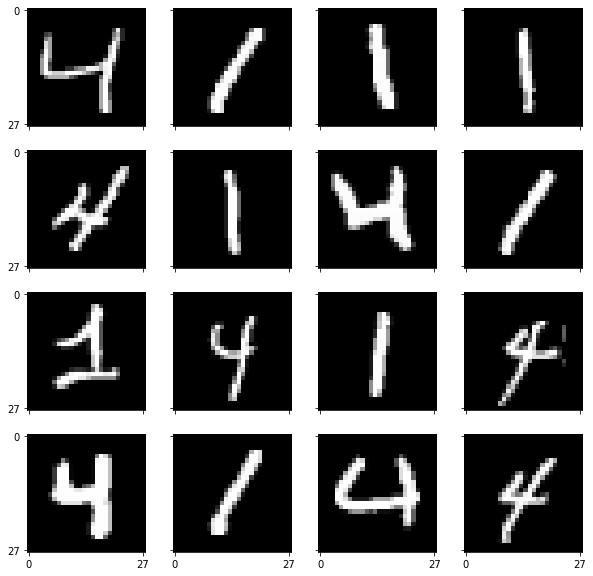

<Figure size 432x288 with 0 Axes>

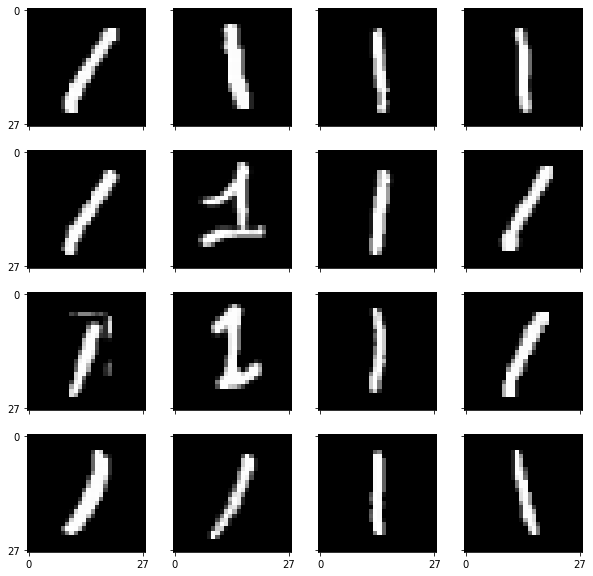

In [33]:
MnistShow(train_images) # Both digits
MnistShow(train_images_digit_A) # Only Digit B

In [16]:
(train_labels[0,:] == digit_A).shape

(12584,)

## Task 4 Converting data matrix to feature vector: Test Images
If this fails, the upcoming calculation are not correct. Make sure the images are the same

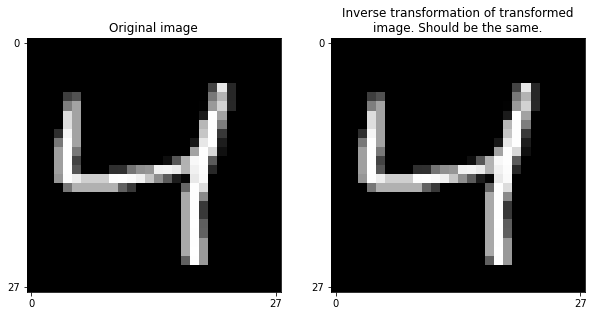

In [4]:
(NFrame, NRow, NCol) = train_images.shape
feature_vectors = matrix2vector(train_images)
images = vector2matrix(feature_vectors, NRow, NCol)

fig, ax = plt.subplots(1,2, figsize=(10,5), subplot_kw=subplot_keywords)
ax[0].imshow(train_images[0])
ax[1].imshow(images[0])
ax[0].set_title("Original image")
ax[1].set_title("Inverse transformation of transformed\nimage. Should be the same.")
plt.plot();

### Task 6: Perform Logistic Regression Gradient

In [28]:
def gradient_descent_logreg(max_iter, step_size, vec_w_init, mat_X, mat_X_digits, weights_filename = "vec_w_opt_logreg", vec_y_filename = "vec_y_logreg"):
    # Number Samples = Number Columns
    N = mat_X.shape[1]
    # Convert the vector of true label mat_X_digits to binary num(0,1) <-> digit(A, B)
    vec_y = map_digit_to_vec_y(mat_X_digits)
    vec_L = []

    for i in np.arange(max_iter):
        # Estimation of y --> y hat
        y_estimate = vec_y_estimate(vec_w_init, mat_X) # shape = (1,N)

        # Cross entropy loss function
        L = -1/N * np.sum(vec_y*np.log(y_estimate)+(1-vec_y)*np.log(1-y_estimate)) # scalar
        vec_L.append(L)

        # Gradient Descent Algorithm
        grad_L= 1/N * np.matmul(mat_X,(y_estimate-vec_y).transpose())
        vec_w_init = vec_w_init - step_size * grad_L
        ### Explanation
        # For the gradient of L(w) I rewrote the sum
        # We have the shapes: (y_estimate-vec_y).shape=(1, N)
        #                     mat_X.shape=(785, N)
        # The sum says, take entry i of (y_estimate-vec_y) and multiply it with vector mat_X[i]
        # which is one whole column. This is the same as mat_X * (y_estimate-vec_y).transpose() and in shapes
        # (785, N) * (N, 1) = (785,1)
        # So the summation over all N samples is hidden in the matrix multiplication for each row in mat_X

    return (vec_L, vec_w_init)

def vec_y_estimate(vec_w_init, mat_X):
    exp_argument = np.matmul(vec_w_init.transpose(), mat_X) # shape = (1,N)
    return 1.0/(1+np.exp(-exp_argument)) # shape = (1,N)

def map_digit_to_vec_y(mat_X_digits):
    vec_y = np.zeros((1,mat_X_digits.shape[1])) # digit A entries to 0
    digit_B_mask = mat_X_digits[0,:] == digit_B
    digit_B_mask = np.expand_dims(digit_B_mask,axis=0)  # Shape (1,N)
    vec_y[digit_B_mask] = 1  # digit B entries to 1
    return vec_y
    

def compute_output_vec_y (vec_w_opt_lda, mat_X):
    return np.matmul(np.transpose(vec_w_opt_lda), mat_X)

def predict_one_y (vec_w_opt_lda, x, digit_A, digit_B):
    vec_y_lda = compute_output_vec_y(vec_w_opt_lda, x)
    if vec_y_lda > 0: 
        return digit_A
    else:
        return digit_B

def matrix2vector(images):
    images = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
    return np.transpose(images)


# Inverse transformation of feature vector in image
def vector2matrix(feature_vector, NCol, NRow):
    # return feature_vector.reshape((feature_vector.shape[0], NCol, NRow))
    feature_vector = np.transpose(feature_vector)
    return feature_vector.reshape((feature_vector.shape[0], NCol, NRow))

def learn_lda(mat_X_digitA, mat_X_digitB, mat_X_digit, weights_filename = "vec_w_opt_lda", vec_y_filename = "vec_y_lda"):
    n_1 = mat_X_digitA.shape[1]
    m_1 = 1.0/n_1 * np.sum(mat_X_digitA, axis=1)
    m_1 = m_1.reshape(m_1.shape[0],1)
    
    # Create matrix of ones, so we artificially copy m_1 to new columns for a matrix 
    # This is helpful for mat_X_digitA - m_1
    ones = np.ones(mat_X_digitA.shape[1]).reshape(1, mat_X_digitA.shape[1])
    m_1_mat = np.matmul(m_1, ones)
    print(f"Step 1 / 5: Shape m_1_mat: {m_1_mat.shape} Shape mat_X_digitA: {mat_X_digitA.shape}")
    S_1 = np.matmul((mat_X_digitA-m_1_mat), np.transpose(mat_X_digitA-m_1_mat))

    # Same for digit B
    n_2 = mat_X_digitB.shape[1]
    m_2 = 1.0/n_2 * np.sum(mat_X_digitB, axis=1)
    m_2 = m_2.reshape(m_2.shape[0],1)
    
    ones = np.ones(mat_X_digitB.shape[1]).reshape(1, mat_X_digitB.shape[1])
    m_2_mat = np.matmul(m_2, ones)
    print(f"Step 2 / 5: Shape m_2_mat: {m_2_mat.shape} Shape mat_X_digitB: {mat_X_digitB.shape}")
    S_2 = np.matmul((mat_X_digitB-m_2_mat), np.transpose(mat_X_digitB-m_2_mat))
    
    S_W = S_1 + S_2
    print(f"Step 3 / 5: Shape S_W: {S_W.shape}")
    
    S_W_inv = np.linalg.pinv(S_W) # Use Moore-Penrose pseudo-inverse of a matrix
    vec_w_opt_lda = np.matmul(S_W_inv, (m_1 - m_2))
    print(f"Step 4 / 5: Shape vec_w_opt_lda: {vec_w_opt_lda.shape}")

    vec_y_lda = compute_output_vec_y(vec_w_opt_lda, mat_X_digit)
    print(f"Step 5 / 5: Shape vec_y_lda: {vec_y_lda.shape}")
    return [vec_w_opt_lda, vec_y_lda, m_1, m_2]

Step 1 / 5: Shape m_1_mat: (784, 6742) Shape mat_X_digitA: (784, 6742)
Step 2 / 5: Shape m_2_mat: (784, 5842) Shape mat_X_digitB: (784, 5842)
Step 3 / 5: Shape S_W: (784, 784)
Step 4 / 5: Shape vec_w_opt_lda: (784, 1)
Step 5 / 5: Shape vec_y_lda: (1, 12584)


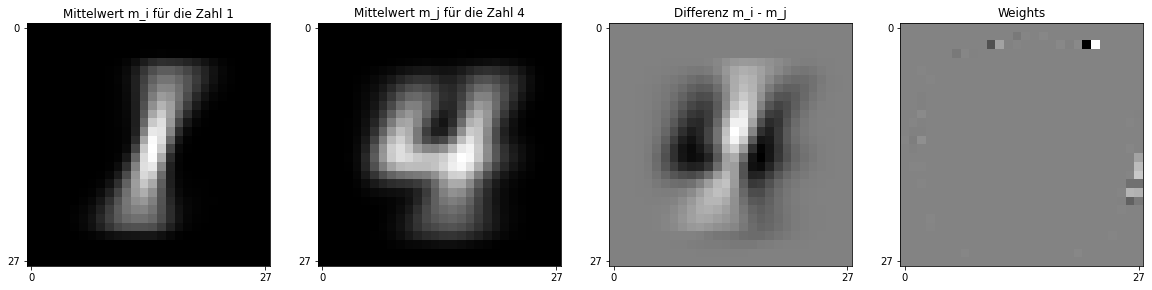

In [30]:
(NFrame, NRow, NCol) = train_images_digit_A.shape
[vec_w_opt_lda, vec_y_lda, m_1, m_2] = learn_lda(matrix2vector(train_images_digit_A), matrix2vector(train_images_digit_B), matrix2vector(train_images))

mat_weights = vec_w_opt_lda.reshape(NRow, NCol)
fig, ax = plt.subplots(1,4,figsize=(20,5), subplot_kw=subplot_keywords)
ax[0].imshow(m_1.reshape(NRow, NCol))
ax[0].set_title(f"Mittelwert m_i für die Zahl {digit_A}")

ax[1].imshow(m_2.reshape(NRow, NCol))
ax[1].set_title(f"Mittelwert m_j für die Zahl {digit_B}")

ax[2].imshow((m_1-m_2).reshape(NRow, NCol))
ax[2].set_title(f"Differenz m_i - m_j")

ax[3].imshow(vec_w_opt_lda.reshape(NRow, NCol))
ax[3].set_title(f"Weights")

plt.show()

In [ ]:
mat_X_digits = train_labels
vec_y = np.zeros((1, mat_X_digits.shape[1])) 
digit_B_mask = mat_X_digits[0,:] == digit_B
digit_B_mask = np.expand_dims(digit_B_mask,axis=0)  #(1,N)
vec_y[digit_B_mask] = 1

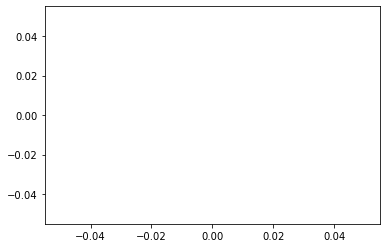

In [ ]:
mat_X = train_images_feature_vec
mat_X_digits = train_labels
vec_L = []
vec_y = map_digit_to_vec_y(mat_X_digits)
N = mat_X.shape[1]
vec_w_init = np.zeros((NRow*NCol+1,1))+0.1
exp_argument = np.matmul(vec_w_init.transpose(), mat_X) # shape = (1,N)
y_estimate = 1.0/(1+np.exp(-np.matmul(vec_w_init.transpose(), mat_X))) # shape = (1,N)
L = -1.0/N * np.sum(vec_y*np.log(y_estimate)+(1-vec_y)*np.log(1-y_estimate))

# For the gradient of L(w) I rewrote the sum
# We have the shapes: (y_estimate-vec_y).shape=(1, N)
#                     mat_X.shape=(785, N)
# The sum says, take entry i of (y_estimate-vec_y) and multiply it with vector mat_X[i]
# which is one whole column. This is the same as mat_X * (y_estimate-vec_y).transpose() and in shapes
# (785, N) * (N, 1) = (785,1)
# So the summation is hidden in the matrix multiplication for each row in mat_X


grad_L_sum = np.matmul(mat_X,(y_estimate-vec_y).transpose())
grad_L = 1/N * grad_L_sum

# The same
grad_L_2 = 1/N * (y_estimate[0,0]-vec_y[0,0])*mat_X[:,0]
for i in np.arange(N-1):
    grad_L_2 += 1/N * (y_estimate[0,i+1]-vec_y[0,i+1])*mat_X[:,i+1]

# max_iter = 100
# step_size = 0.01
# for i in np.arange(max_iter):
#     y_estimate = 1.0/(1+np.exp(-np.matmul(vec_w_init.transpose(), mat_X))) # shape = (1,N)
#     L = -1/N * np.sum(vec_y*np.log(y_estimate)+(1-vec_y)*np.log(1-y_estimate))
#     vec_L.append(L)
#     grad_L= 1/N * np.matmul(mat_X,(y_estimate-vec_y).transpose())
#     vec_w_init = vec_w_init - step_size * grad_L


plt.plot(vec_L)

In [ ]:
np.sum(grad_L-grad_L_2)

-4.0243364196612674e-12

In [ ]:
np.sum(vec_y*np.log(y_estimate)+(1-vec_y)*np.log(1-y_estimate))

-52005.084920985406

Text(0.5, 1.0, 'Corresponding weights matrix')

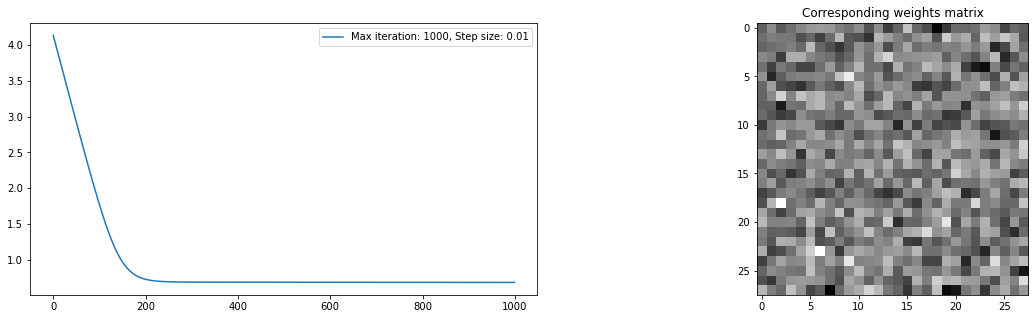

In [ ]:
(NFrame, NRow, NCol) = train_images.shape
train_images_feature_vec = matrix2vector(train_images)
vec_w_init = np.zeros((NRow*NCol+1,1))+0.1

max_iter = 1000
step_size = 0.01
(vec_L, optimal_w_vec) = gradient_descent_logreg(max_iter, step_size, vec_w_init, train_images_feature_vec, train_labels)
optimal_w_mat = vector2matrix(optimal_w_vec, NRow, NCol)

# Plot Results
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(vec_L, label=f"Max iteration: {max_iter}, Step size: {step_size}")
ax[1].imshow(optimal_w_mat[0])

ax[0].legend()
ax[1].set_title("Corresponding weights matrix")

In [ ]:
test = train_images_feature_vec.transpose()[0]
test = np.expand_dims(test, axis=1)

In [ ]:
vec_y_estimate(optimal_w_vec, test)

array([[0.42324236]])

### 6 Model Accuracy
The method gives a high accuracy around 97%-99% even when the test data set is used. The Accuracy depends on the used numbers. Numbers which are more similar have a smaller pair accuracy. 

In [ ]:
def compute_accuracy(vec_y_lda, vec_y_true, digit_A, digit_B):
    vec = (np.zeros(vec_y_lda.shape[1]))
    vec_y_lda = vec_y_lda.flatten()
    vec[vec_y_lda[:] > 0] = digit_A
    vec[vec_y_lda[:] <= 0] = digit_B
    vec_true_false = vec[vec == vec_y_true]

    return len(vec_true_false)/len(vec_y_true)

In [ ]:
vec_y_lda = compute_output_vec_y(vec_w_opt_lda, matrix2vector(train_images))
accuracy = compute_accuracy(vec_y_lda, train_labels, digit_A, digit_B)
print(f"Train data: The Accuracy of the model with digit A: {digit_A} and digit B: {digit_B} is: {accuracy:.5f}")

vec_y_lda = compute_output_vec_y(vec_w_opt_lda, matrix2vector(test_images))
accuracy = compute_accuracy(vec_y_lda, test_labels, digit_A, digit_B)
print(f"Test data:  The Accuracy of the model with digit A: {digit_A} and digit B: {digit_B} is: {accuracy:.5f}")

Train data: The Accuracy of the model with digit A: 1 and digit B: 4 is: 0.46424
Test data:  The Accuracy of the model with digit A: 1 and digit B: 4 is: 0.46386


### 7. Test model with test dataset and show the classification

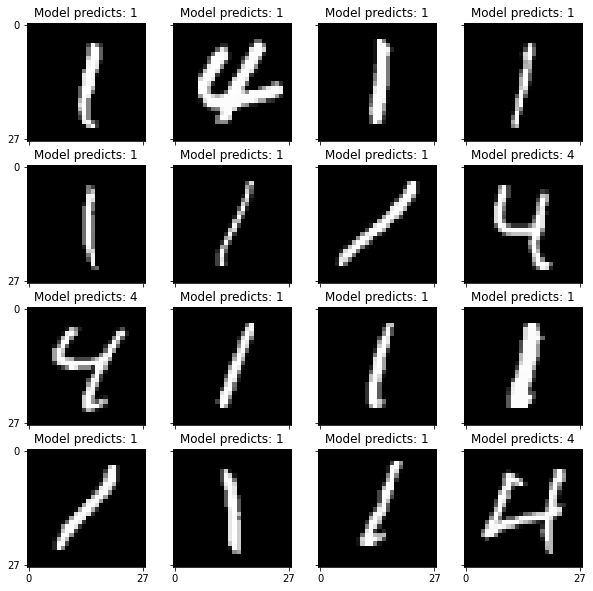

In [ ]:
mat_weights = vec_w_opt_lda.reshape(NRow, NCol)

num_grid = 4
fig, ax = plt.subplots(num_grid, num_grid, figsize=(10,10), subplot_kw=subplot_keywords, sharex=True, sharey=True)

# Take some random examples from the test dataset and show the prediction
train_images_digit_A_vec, train_images_digit_B_vec = matrix2vector(train_images_digit_A), matrix2vector(train_images_digit_B)
Test1, Test2, Test3 = train_images_digit_A_vec[:,3], train_images_digit_A_vec[:,600], train_images_digit_B_vec[:,600]

test_images_vec = matrix2vector(test_images)
for i in np.arange(num_grid):
    for j in np.arange(num_grid):
    # Take some random examples from the test dataset and show the prediction
        max_int = test_images_vec.shape[1]
        rand = np.random.randint(0, max_int)
        Example_data = test_images_vec[:,rand]
        prediction = predict_one_y(vec_w_opt_lda, Example_data, digit_A, digit_B)
        ax[i,j].imshow(Example_data.reshape(NRow, NCol))
        ax[i,j].set_title(f"Model predicts: {prediction}")
plt.show()

In [ ]:
(NFrame, NRow, NCol) = test_images.shape
feature_vectors = matrix2vector(test_images)

In [ ]:
feature_vectorsold = matrix2vectorold(test_images)
a = feature_vectorsold[0]
b= feature_vectors[0]

In [ ]:
# Create a feature vector of each image
def matrix2vectorold(images):
    images = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
    return np.transpose(images)

In [ ]:
(NFrame, NRow, NCol) = test_images.shape
feature_vectors = matrix2vector(test_images)
a1 = vector2matrix(feature_vectors,NRow,NCol)

In [ ]:
test_labels
map_digit_to_vec_y(test_labels)[2:20]

array([0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
       0.])

In [47]:
feature_vectorsold = matrix2vectorold(train_images)[:,0]
feature_vectors = matrix2vector(train_images)[:,0]
feature_vectors2 = matrix2vector(train_images)[0,:]

np.sum(feature_vectors)
np.sum(feature_vectorsold)

76.24705882352941

In [51]:
images = np.array([[[1.1,1.2],[1.3,1.4]], [[2.1,2.2],[2.3,2.4]], [[3.1,3.2],[3.3,3.4]]])
print(images.shape)